In [6]:
# imports
from inspect import signature

import scipy
import psopy
import gamod
import tsmod
import sysid
import ssid

import parid

from ipywidgets import interact, interactive, interact_manual
from IPython.display import display
import IPython.display as dis
import ipywidgets as wid

import time
import os.path

import random
import pandas
import numpy
import control
from matplotlib import pyplot as plt
import importlib

A = [[0.90483742]]

B = [[0.09055917]]

C = [[1.]]

D = [[0.04837418]]



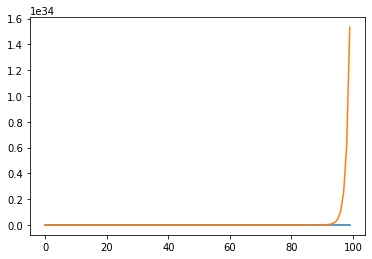

In [110]:
# test sysid

ts = range(100)
us = [rect(t, 10, 50, 100) for t in ts]
_, ys, _ = control.forced_response(control.tf([1], [10,1]), T=ts, U=us)
plt.plot(ts, ys)

def sysid_id(y, u):
    ss1_id = sysid.subspace_det_algo1(y, u, f=2, p=2, s_tol=1e-2, dt=1)
    tf = control.ss(ss1_id.A, ss1_id.B, ss1_id.C, ss1_id.D)
    _, ys, _ = control.forced_response(tf, T=ts, U=us)
    print(tf)
    return ts, ys

id = sysid_id(ys, us)
plt.plot(id[0], id[1])

# this module gives questionable results

ValueError: all the input array dimensions except for the concatenation axis must match exactly

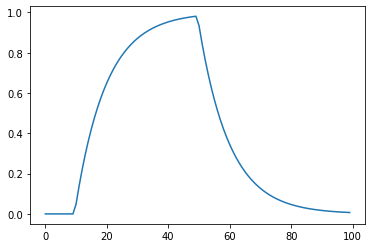

In [95]:
# try a different module
importlib.reload(ssid)

ts = range(100)
us = [rect(t, 10, 50, 100) for t in ts]
_, ys, _ = control.forced_response(control.tf([1], [10,1]), T=ts, U=us)
plt.plot(ts, ys)

def subspace_id(y, u):
    u, y = numpy.array([u]), numpy.array([y])
    A, B, C, D, Cov, S = ssid.N4SID(u, y, 100, 100, 4)
    tf = control.ss(A, B, C, D)
    _, ys, _ = control.forced_response(tf, T=ts, U=us)
    plt.plot(ts, ys) 
    return tf.num, tf.den

subspace_id(ys, us)

# "TypeError: 'float' object cannot be interpreted as an integer" but I cannot see where to correct it
# the above error exists even in the example code from the N4SID github when run https://github.com/AndyLamperski/pyN4SID/blob/master/N4SIDtest.ipynb

A = [[0.90483742]]

B = [[-0.09961931]]

C = [[-0.95143914]]

D = [[0.]]



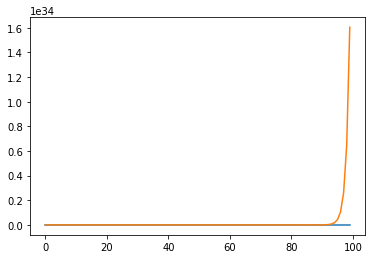

In [116]:
# try SIPPY https://github.com/CPCLAB-UNIPI/SIPPY.git (requires slycot)
import sippy

ts = range(100)
us = [rect(t, 10, 50, 100) for t in ts]
_, ys, _ = control.forced_response(control.tf([1], [10,1]), T=ts, U=us)
plt.plot(ts, ys)

def sippy_id(y, u):
    u, y = numpy.array(u), numpy.array(y)
    sys_id = sippy.system_identification(y, u, 'N4SID', SS_fixed_order=1)
    tf = control.ss(sys_id.A, sys_id.B, sys_id.C, sys_id.D)
    _, ys, _ = control.forced_response(tf, T=ts, U=us)
    print(tf)
    return ts, ys

id = sippy_id(ys, us)
plt.plot(id[0], id[1])

# similar problem as sysid?

A = [[0.90483742]]

B = [[-0.09961931]]

C = [[-0.95143914]]

D = [[0.]]

A = [[0.90483742]]

B = [[0.09055917]]

C = [[1.]]

D = [[0.04837418]]



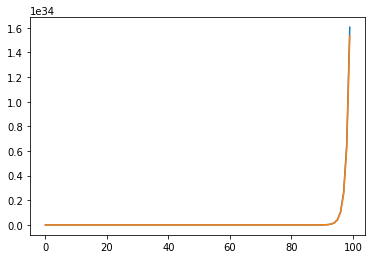

In [113]:
sipid = sippy_id(ys, us)
syid = sysid_id(ys, us)
t = sipid[0]

plt.plot(t, sipid[1])
plt.plot(t, syid[1])

In [3]:
import parid
importlib.reload(parid)
est = parid.Estimate()

In [4]:
def sim(Input='Step', Noise="None", Technique='Tabu Search'):

    Load_Name = wid.Text(value='', description='Load Name', disabled=False)
    run_load = wid.Button(description="Load", disabled=False)
    load_state = False
    
    def run_load_clicked(b):
        with output:
            dis.clear_output(True)
            global ts, ym, us
            ydata, udata, tdata = est.load_data(Load_Name.value)
            ts, ym, us = tdata, ydata, udata
            global load_state
            load_state = True
            
            plt.plot(ts, ym, label="Loaded")
            plt.legend()
            plt.show()
            
    run_load.on_click(run_load_clicked)
    
    u = est.input_dict[Input]
    u_sig = u.__code__.co_varnames[1:]
    c_input_params = {}
    c_input_wid = {}
    for var in u_sig:
        
        c_input_wid[var] = wid.IntSlider(value=1, min=0, max=600, description=var, disabled=False)
        display(c_input_wid[var])
        
    n = est.noise_dict[Noise]
    n_sig = n.__code__.co_varnames[1:]
    c_noise_params = {}
    c_noise_wid = {}
    for var in n_sig:
        c_noise_wid[var] = wid.FloatSlider(value=0, min=0, max=0.5, step=0.01, description=var, disabled=False)
        display(c_noise_wid[var])
    
    sys = est.create_system
    sys_sig = sys.__code__.co_varnames
    c_sys_params = {}
    c_sys_wid = {}
    for var in sys_sig:
        c_sys_wid[var] = wid.Text(value='1', description=var, disabled=False)
        display(c_sys_wid[var])
        
    tech = est.tech_dict[Technique]
    tech_sig = tech.__code__.co_varnames[1:]
    for names in tech_sig:
        display(names+"(inputs separated by a semicolon):")
    
    c_tech_wid = {}
    for var1 in tech_sig:
        for var2 in sys_sig:
            var = str(var1) + str(var2)
            c_tech_wid[var] = wid.Text(value='1', description=var2, disabled=False)
            display(c_tech_wid[var])
    
    Save_Name = wid.Text(value='', description='Save Name', disabled=False)
    display(Save_Name)
    display(Load_Name)
    
    run_sim = wid.Button(description='Simulate')
    run_est = wid.Button(description='Estimate')
    
    run_state = False
    
    output = wid.Output()

    def run_sim_clicked(b):
        with output:
            dis.clear_output(True)
            global ts, ym, us
            
            for var in u_sig:
                c_input_params[var] = c_input_wid[var].value
                
            for var in n_sig:
                c_noise_params[var] = c_noise_wid[var].value
            
            for var in sys_sig:
                c_sys_params[var] = [float(i) for i in c_sys_wid[var].value.split(';')]
            
            ts = numpy.linspace(0, c_input_params['stop'], c_input_params['stop']*1)
            us = [u(t, *c_input_params.values()) for t in ts]
            
            system = est.create_system(*c_sys_params.values()) 
            print(system)
            tm, y1, xm = control.forced_response(system, T=ts, U=us)
            
            ym = n(y1, *c_noise_params.values())
            
            plt.plot(tm, ym, label="Real")
            plt.legend()            
            plt.show()
        
    def run_est_clicked(b):
        with output:
            dis.clear_output(True)
            arr_tech_params = []
            orders = []
            
            for o, var in enumerate(c_tech_wid):
                orders.append(len(c_tech_wid[var].value.split(';')))
                for k in range(orders[o]):
                    arr_tech_params.append([float(j) for j in [i.split(',') for i in c_tech_wid[var].value.split(';')][k]]) 
            
            div = orders[0]
            
            def err_wrap(params):
                return est.err(params, ts, ym, us, div)
        
            def res_wrap(params):
                return est.res(params, ts, ym, us, div)
            
            print('Running...')
            st = time.time()
            coeff = tech(err_wrap, arr_tech_params)
            et = time.time()
            print('Done.')
            
            dur = et-st
            print("Parameters estimated as {} in {} seconds".format(coeff, dur))
            
            plt.plot(ts, ym, label="Real/Loaded")
            yres = res_wrap(coeff)
            
            global d
            d = ts, ym, us, yres, dur, coeff, div
            
            plt.legend()            
            plt.show()
            run_state = True            
    
    display(run_sim)
    display(run_est, output)
    
    run_sim.on_click(run_sim_clicked)
    run_est.on_click(run_est_clicked)
    
    run_save = wid.Button(description="Save", disabled=run_state)
    
    display(run_save)
    display(run_load)
    
    def run_save_clicked(b):
        with output:
            est.save_data(d, Save_Name.value)
            
    run_save.on_click(run_save_clicked)

In [5]:
interact(sim, 
         Input=[keys for keys, dict in est.input_dict.items()], 
         Noise=[keys for keys, dict in est.noise_dict.items()],
         Technique=[keys for keys, dict in est.tech_dict.items()])

interactive(children=(Dropdown(description='Input', options=('Step', 'Rect', 'Doublet'), value='Step'), Dropdo…

<function __main__.sim(Input='Step', Noise='None', Technique='Tabu Search')>

In [10]:
class Test:
    
    def __init__(self):
        self.methods = []

    def func1(a):
        return print(f'is this working? {a}')

    def func2():
        return "func2"

    l = locals()
    
    def method_list(self):
        for f in dir(self):
            if callable(getattr(self, f)) and not f.startswith("_") and f != "method_list":
                self.methods.append(f)   
        funcs = [self.l[f] for f in self.methods]
        
        return funcs


In [11]:
t = Test()
t.method_list()[0]('yes')

is this working? yes


In [34]:
class Test:
    
    def __init__(self):
        return None

    def func1(a):
        return print(a)

    def func2(a, b):
        return print(f'first variable = {a}, second variable = {b}')

    l = locals()
    
def method_list(obj):
    methods = []
    for f in dir(obj):
        if callable(getattr(obj, f)) and not f.startswith("_"):
            methods.append(f)   
    funcs = [obj.l[f] for f in methods]
    vars = [f.__code__.co_varnames for f in funcs]
    return list(zip(funcs, vars))

t = Test()
method_list(t)[1][0](*[a for a in method_list(t)[1][1]])

first variable = a, second variable = b


In [120]:
class Pizza:
    def __init__(self, ingredients):
        self.ingredients = ingredients

    def __repr__(self):
        return f'Pizza({self.ingredients!r})'
    
    @classmethod
    def margherita(cls):
        return cls(['mozzarella', 'tomatoes'])

    @staticmethod
    def circle_area(r):
        return r ** 2 * math.pi

In [16]:
class Estimate:
    def __init__(self):
        self.inputs = self.method_list(self.Inputs)
        return None

    class Inputs:
        l = locals()
        
#         @staticmethod
        def step(t, start, stop):
            if t<start:
                return 0
            else:
                return 1

        def rect(t, start, drop, stop):
            if t>=start and t<stop:
                return 1
            else:
                return 0

        def doublet(t, start, drop, rise, stop):
            if t>=start and t<drop:
                return 1
            elif t>=drop and t<rise:
                return -1
            else:
                return 0
    
    def get_inputs(self):
        return self.inputs
    
    @staticmethod
    def method_list(obj):
        methods = []
        for f in dir(obj):
            if callable(getattr(obj, f)) and not f.startswith("_"):
                methods.append(f)   
        funcs = [obj.l[f] for f in methods]
        vars = [f.__code__.co_varnames for f in funcs]
        return list(zip(funcs, vars))

In [17]:
est = Estimate()
est.get_inputs()

[(<function __main__.Estimate.Inputs.doublet(t, start, drop, rise, stop)>,
  ('t', 'start', 'drop', 'rise', 'stop')),
 (<function __main__.Estimate.Inputs.rect(t, start, drop, stop)>,
  ('t', 'start', 'drop', 'stop')),
 (<function __main__.Estimate.Inputs.step(t, start, stop)>,
  ('t', 'start', 'stop'))]